In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

%config InlineBackend.figure_formats = ['svg']

# Physical implementation of a $\cos2\varphi$ qubit 

based on high-transmission Josephson junctions...

### Potentials

Standard tunnel junctions have a potential energy $U(\varphi)=-E_J\cos\varphi$, which in principle, does not have any higher harmonic terms such as $\cos2\varphi$ terms. Junctions with a conduction channel of transmission $\tau$ closer to 1 admit the more general Andreev Bound States (ABS) potential,
\begin{align}
U_\tau(\varphi)=-\Delta\sqrt{1-\tau\sin^2\varphi/2},
\end{align}
providing several higher harmonic terms. The potential is still $2\pi$-periodic and can be expanded in Fourier series,
\begin{align}
U_\tau(\varphi)=-\sum A_k\cos k\varphi
\end{align}
If the junction is tunnel, $\tau$ is small, and only the $\cos\varphi$ term in the expansion is important. When $\tau$ becomes larger, the $\cos2\varphi$ term starts to play a more important role, while still staying smaller than the $\cos\varphi$ term.

We now elucidate these concepts. First, we look at the decomposition of the $U_\tau(\varphi)$. We have assumed that
\begin{align}
U_\tau(\varphi)=-\sum A_k\cos k\varphi,\\
\int_{-\pi}^\pi U_\tau(\varphi)\cos k\varphi d\varphi &= -\sum_{n=0}^\infty A_n\int_{-\pi}^\pi\cos n\varphi \cos k\varphi d\varphi,\\ &= -A_0\int_{-\pi}^\pi \cos k\varphi d\varphi - \sum_{n>0}^\infty A_n\int_{-\pi}^\pi\cos n\varphi \cos k\varphi d\varphi
\end{align}
Note that 
\begin{align}
\int_{-\pi}^\pi\cos n\varphi \cos k\varphi d\varphi = \begin{cases}0, k \neq n,\\
2\pi, k = n = 0,\\
\pi, k = n \neq 0
\end{cases}
\end{align}
Alors
\begin{align}
A_0 = -\dfrac{1}{2\pi}\int_{-\pi}^\pi U_\tau(\varphi)d\varphi,\\
A_k = -\dfrac{1}{\pi}\int_{-\pi}^\pi U_\tau(\varphi)\cos k\varphi d\varphi.
\end{align}

In [4]:
def andreev_potential(varphi, tau, Delta):
    """ 
    The general Andreev potential.

    """
    return - Delta * np.sqrt(1 - tau * np.sin(varphi/2)** 2)

def tunnel(tau, varphi, Delta):
    """ 
    Tunneling junction potential, 1st order expansion of Andreev potential.
    """
    return -(tau/4)*np.cos(varphi)+(tau/4-Delta)


def cal_A0(tau, Delta):
    integral, _ = quad(lambda varphi: andreev_potential(varphi, tau, Delta), -np.pi, np.pi)
    A0 = -integral / (2*np.pi)
    return A0

def cal_Ak(k, tau, Delta):
    def integrand(varphi):
        return andreev_potential(varphi, tau, Delta) * np.cos(k*varphi)
    integral, _ = quad(integrand, -np.pi, np.pi)
    Ak = -integral / np.pi
    return Ak

# def fourier_coefficient(k, tau, Delta, num_points=1000):
#     """
#     Compute the Fourier coefficient A_k for the potential U_tau(phi).
    
#     Parameters:
#         k (int): The Fourier mode.
#         tau (float): The transmission coefficient (0 <= tau <= 1).
#         delta (float): The superconducting gap.
#         num_points (int): Number of integration points.
    
#     Returns:
#         float: The Fourier coefficient A_k.
#     """
#     integrand = lambda phi: andreev_potential(tau, phi, Delta) * np.cos(k * phi)
#     A_k, _ = quad(integrand, -np.pi, np.pi, limit=num_points)
#     return A_k / np.pi

# def compute_fourier_coefficients(tau, Delta, max_k):
#     """
#     Compute the Fourier coefficients A_k for k = 0, 1, ..., max_k.
    
#     Parameters:
#         tau (float): The transmission coefficient (0 <= tau <= 1).
#         delta (float): The superconducting gap.
#         max_k (int): Maximum Fourier mode to compute.
    
#     Returns:
#         list: Fourier coefficients [A_0, A_1, ..., A_max_k].
#     """
#     coefficients = []
#     for k in range(max_k + 1):
#         coefficients.append(fourier_coefficient(k, tau, Delta))
#     return coefficients

# def reconstructed_potential(phi, tau, Delta, max_k):
#     """ 
#     Compute a potential from Fourier coefficients
#     """
#     potential = 0
#     for k in range(max_k + 1):
#         A_k = fourier_coefficient(k, tau, Delta)
#         potential += A_k * np.cos(k * phi)
#     return potential

We first try a value of $\tau=0.98$. This is quite high. Let $\Delta=1$.

In [5]:
tau_0 = 0.98
Delta_0 = 1

In [7]:
Fourier_decomp = []

A0 = cal_A0(tau_0, Delta_0)
Fourier_decomp.append(A0)
num_coefs = 3
for k in range(1, num_coefs+1):
    Ak = cal_Ak(k, tau_0, Delta_0)
    Fourier_decomp.append(Ak)

Fourier_decomp

[0.6548236085639082,
 0.3962636531899406,
 -0.0680207004550399,
 0.024301827345034905]

In [38]:
coefficients = compute_fourier_coefficients(tau=tau_0, Delta=Delta_0, max_k=3)

coefficients

[-1.3096472171278164,
 -0.3962636531899406,
 0.0680207004550399,
 -0.024301827345034905]

The smallest higher-order coefficient is $10^{-2}$, for $k = 3$.

In [35]:
varphi_range = np.linspace(-np.pi, np.pi, 100)

reconstructed_potential_values = [
    reconstructed_potential(phi, tau=tau_0, Delta=Delta_0, max_k=3) for phi in varphi_range
]

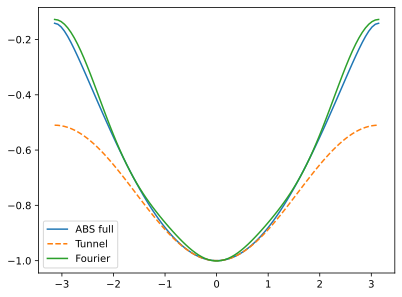

In [44]:
fig, ax = plt.subplots()
ax.plot(varphi_range, [andreev_potential(tau_0, varphi, 1) for varphi in varphi_range], label='ABS full')
ax.plot(varphi_range, [tunnel(tau_0, varphi, 1) for varphi in varphi_range], linestyle='--', label='Tunnel')
ax.plot(varphi_range, reconstructed_potential_values-np.array(coefficients[0])/2, label='Fourier')
ax.legend()

Using only 3 terms in the Fourier series, the potential is performing quite good actually. We plot here the $\cos$ at each order.

In [41]:
reconstructed_potential_values

[np.float64(-0.7824243184037465),
 np.float64(-0.7843601846570815),
 np.float64(-0.7901362237607534),
 np.float64(-0.7996585978331789),
 np.float64(-0.8127736871685082),
 np.float64(-0.8292721622864824),
 np.float64(-0.8488945018878375),
 np.float64(-0.8713377813278038),
 np.float64(-0.896263516564025),
 np.float64(-0.9233063162093981),
 np.float64(-0.9520830704093642),
 np.float64(-0.9822023905556809),
 np.float64(-1.0132740088099763),
 np.float64(-1.044917851166812),
 np.float64(-1.0767725121211396),
 np.float64(-1.1085028823683658),
 np.float64(-1.1398067124922706),
 np.float64(-1.1704199341400596),
 np.float64(-1.2001206043573778),
 np.float64(-1.2287313869809273),
 np.float64(-1.2561205355502045),
 np.float64(-1.2822013933178922),
 np.float64(-1.3069304758169011),
 np.float64(-1.3303042483422967),
 np.float64(-1.3523547530066506),
 np.float64(-1.3731442762802692),
 np.float64(-1.3927592769111483),
 np.float64(-1.411303814879296),
 np.float64(-1.4288927339231585),
 np.float64(-1.44

In [42]:
np.array(coefficients[0])/2

np.float64(-0.6548236085639082)

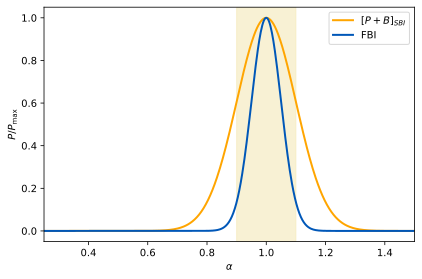

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
x = np.linspace(0.25, 1.5, 500)
y1 = np.exp(-((x - 1.0)**2) / (2 * 0.1**2))  # Gaussian curve 1
y2 = np.exp(-((x - 1.0)**2) / (2 * 0.05**2))  # Gaussian curve 2

# Normalizing for P/P_max
y1 /= y1.max()
y2 /= y2.max()

# Define colors
orange = "#FFA500"  # Orange color
blue = "#0057B8"    # Deep blue color
light_beige = "#F3E5AB"  # Light beige color

# Create the plot
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the curves
ax.plot(x, y1, label=r"$[P+B]_{SBI}$", color=orange, lw=2)
ax.plot(x, y2, label="FBI", color=blue, lw=2)

# Add shaded region
ax.axvspan(0.9, 1.1, color=light_beige, alpha=0.5)

# Labels, legend, and limits
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$P / P_\mathrm{max}$")
ax.legend()
ax.set_xlim(0.25, 1.5)

plt.tight_layout()
plt.show()
